In [ ]:
pip install keras==2.14

In [ ]:
pip install tensorflow==2.13.0

In [ ]:
pip install scikeras

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
train = pd.read_csv("train_final.csv", index_col=['date'], parse_dates=['date'])
test = pd.read_csv("test_final.csv", index_col=['date'], parse_dates=['date'])

In [10]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [11]:
train = train[['new_confirmed','new_deceased', 'cumulative_deceased', 'population', 'population_male', 'population_female', 'latitude', 'longitude','area_sq_km', 'life_expectancy', 'mobility_workplaces', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'gdp_per_capita_usd','day_of_week', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
test = test[['new_confirmed','new_deceased', 'cumulative_deceased', 'population', 'population_male', 'population_female', 'latitude', 'longitude','area_sq_km', 'life_expectancy', 'mobility_workplaces', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'gdp_per_capita_usd','day_of_week', 'quarter', 'month', 'year', 'dayofyear' ,'dayofmonth', 'weekofyear']]

In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Sequential

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

In [14]:
def process(df):
    df.insert(1, 'lag1_new_confirmed', df['new_confirmed'].shift(1).fillna(0))
    return df

train=process(train)
test=process(test)

In [15]:
train.isnull().sum().sort_values(ascending = False)

new_confirmed                          0
lag1_new_confirmed                     0
dayofmonth                             0
dayofyear                              0
year                                   0
month                                  0
quarter                                0
day_of_week                            0
gdp_per_capita_usd                     0
cumulative_persons_fully_vaccinated    0
new_persons_fully_vaccinated           0
mobility_workplaces                    0
life_expectancy                        0
area_sq_km                             0
longitude                              0
latitude                               0
population_female                      0
population_male                        0
population                             0
cumulative_deceased                    0
new_deceased                           0
weekofyear                             0
dtype: int64

In [16]:
test.isnull().sum().sort_values(ascending = False)

new_confirmed                          0
lag1_new_confirmed                     0
dayofmonth                             0
dayofyear                              0
year                                   0
month                                  0
quarter                                0
day_of_week                            0
gdp_per_capita_usd                     0
cumulative_persons_fully_vaccinated    0
new_persons_fully_vaccinated           0
mobility_workplaces                    0
life_expectancy                        0
area_sq_km                             0
longitude                              0
latitude                               0
population_female                      0
population_male                        0
population                             0
cumulative_deceased                    0
new_deceased                           0
weekofyear                             0
dtype: int64

In [17]:
def normalize(df):
    for col in df.columns:
        if col != 'new_confirmed':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df
train=normalize(train)
test=normalize(test)

In [18]:
def make_series(data):
    series=[]
    for i in range(len(data)-15):
        subdf=data[i:i+15]
        series.append( (subdf.index[-1], subdf['new_confirmed'].values[-1], subdf.drop('new_confirmed', axis=1).values))
    return series
train=make_series(train)
test=make_series(test)

In [19]:
inputs = keras.layers.Input(shape=(15,21))
lstm_out = keras.layers.LSTM(30)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

In [13]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [105]:
x=np.array([x[2].reshape(15,21) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
model.fit(x=x,y=y,epochs=100,batch_size=30,shuffle=True)

(67137, 15, 21)
(67137,)
Epoch 1/100
2238/2238 [==============================] - 15s 6ms/step - loss: 7361645.5000
Epoch 2/100
2238/2238 [==============================] - 12s 6ms/step - loss: 7263541.5000
Epoch 3/100
2238/2238 [==============================] - 12s 6ms/step - loss: 7172343.0000
Epoch 4/100
2238/2238 [==============================] - 12s 6ms/step - loss: 7085536.5000
Epoch 5/100
2238/2238 [==============================] - 12s 5ms/step - loss: 7002265.0000
Epoch 6/100
2238/2238 [==============================] - 12s 5ms/step - loss: 6922007.5000
Epoch 7/100
2238/2238 [==============================] - 12s 5ms/step - loss: 6843938.5000
Epoch 8/100
2238/2238 [==============================] - 12s 6ms/step - loss: 6770725.0000
Epoch 9/100
2238/2238 [==============================] - 13s 6ms/step - loss: 6698550.0000
Epoch 10/100
2238/2238 [==============================] - 13s 6ms/step - loss: 6629404.0000
Epoch 11/100
2238/2238 [==============================] - 13s 6m

In [106]:
train_pred_NoTuning=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_pred_NoTuning.head()

2099/2099 [==============================] - 5s 2ms/step


,yhat
2020-03-15,2.229538
2020-03-16,62.036682
2020-03-17,2.891495
2020-03-18,68.776054
2020-03-19,81.569702


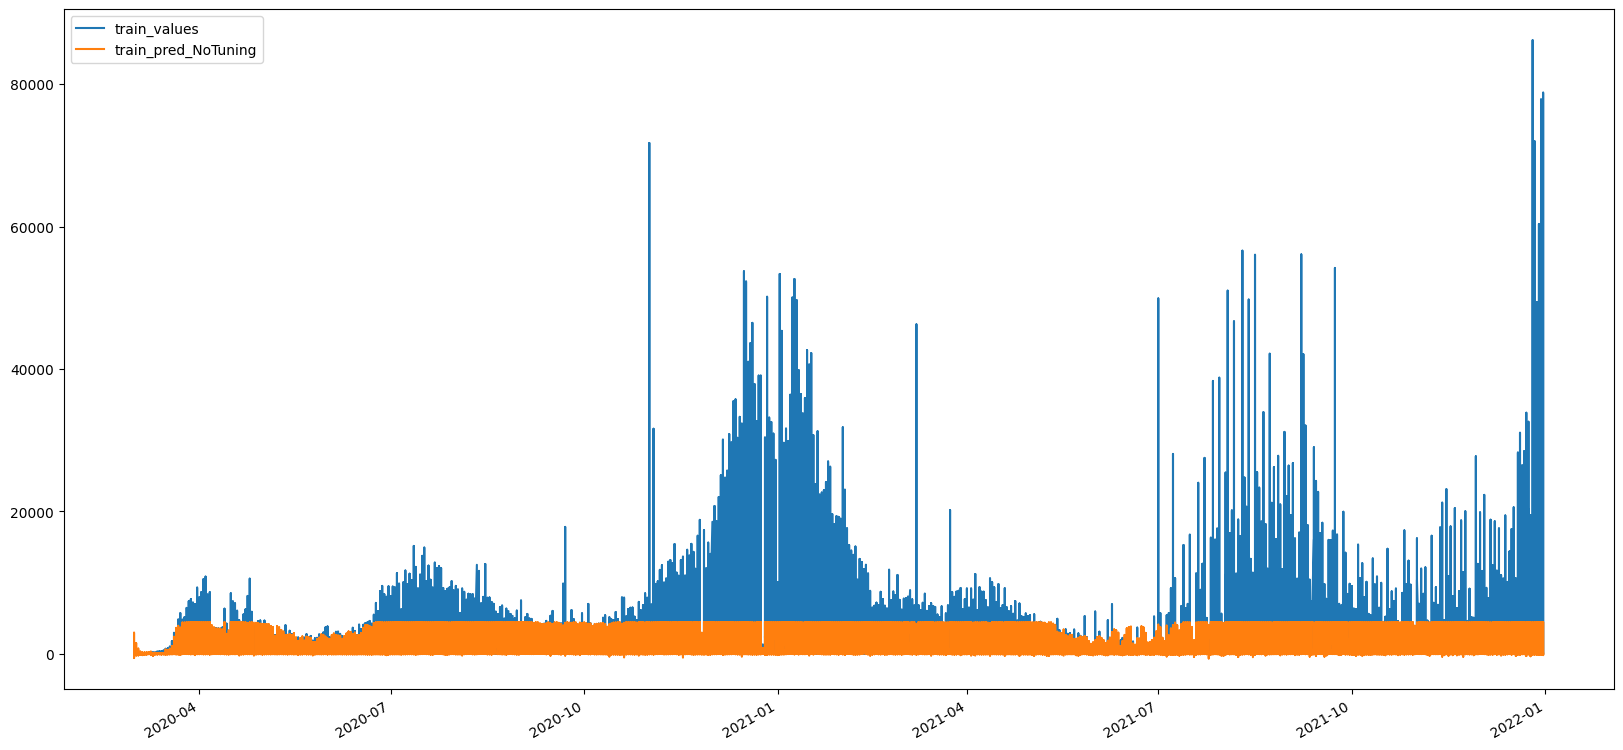

In [107]:
train_values= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_values, train_pred_NoTuning], axis=1).plot(figsize=(20,10))
plt.legend(['train_values', 'train_pred_NoTuning'])

In [108]:
# train rmse without tuning
np.sqrt(mean_squared_error(train_values, train_pred_NoTuning))

1956.934388184785

In [ ]:
# tuning hyperparameters
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
param_grid = {'batch_size': [20,30,50,70,90],
               'epochs':[50,100,200]}

model = Sequential()
model.add(keras.layers.LSTM(units = 100, return_sequences=True, input_shape=((15,21))))
model.add(keras.layers.Dropout(0.2))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss = 'mse')

model = KerasRegressor(build_fn=model)

cv = KFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=model,
                             param_distributions = param_grid, n_iter = 100,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                             scoring = 'neg_root_mean_squared_error')

optimal_params.fit(x, y)

In [23]:
final_model = keras.Model(inputs=inputs, outputs=outputs)
final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
final_model.fit(x=x,y=y,epochs=200,batch_size=90,shuffle=True)

Epoch 1/200
746/746 [==============================] - 6s 6ms/step - loss: 6240487.5000
Epoch 2/200
746/746 [==============================] - 4s 6ms/step - loss: 6217931.5000
Epoch 3/200
746/746 [==============================] - 4s 6ms/step - loss: 6194028.5000
Epoch 4/200
746/746 [==============================] - 5s 6ms/step - loss: 6172505.5000
Epoch 5/200
746/746 [==============================] - 5s 6ms/step - loss: 6149591.0000
Epoch 6/200
746/746 [==============================] - 5s 6ms/step - loss: 6127618.5000
Epoch 7/200
746/746 [==============================] - 4s 6ms/step - loss: 6106506.0000
Epoch 8/200
746/746 [==============================] - 5s 6ms/step - loss: 6084346.0000
Epoch 9/200
746/746 [==============================] - 4s 6ms/step - loss: 6062941.5000
Epoch 10/200
746/746 [==============================] - 4s 6ms/step - loss: 6042350.0000
Epoch 11/200
746/746 [==============================] - 4s 6ms/step - loss: 6021080.0000
Epoch 12/200
746/746 [========

2099/2099 [==============================] - 4s 2ms/step


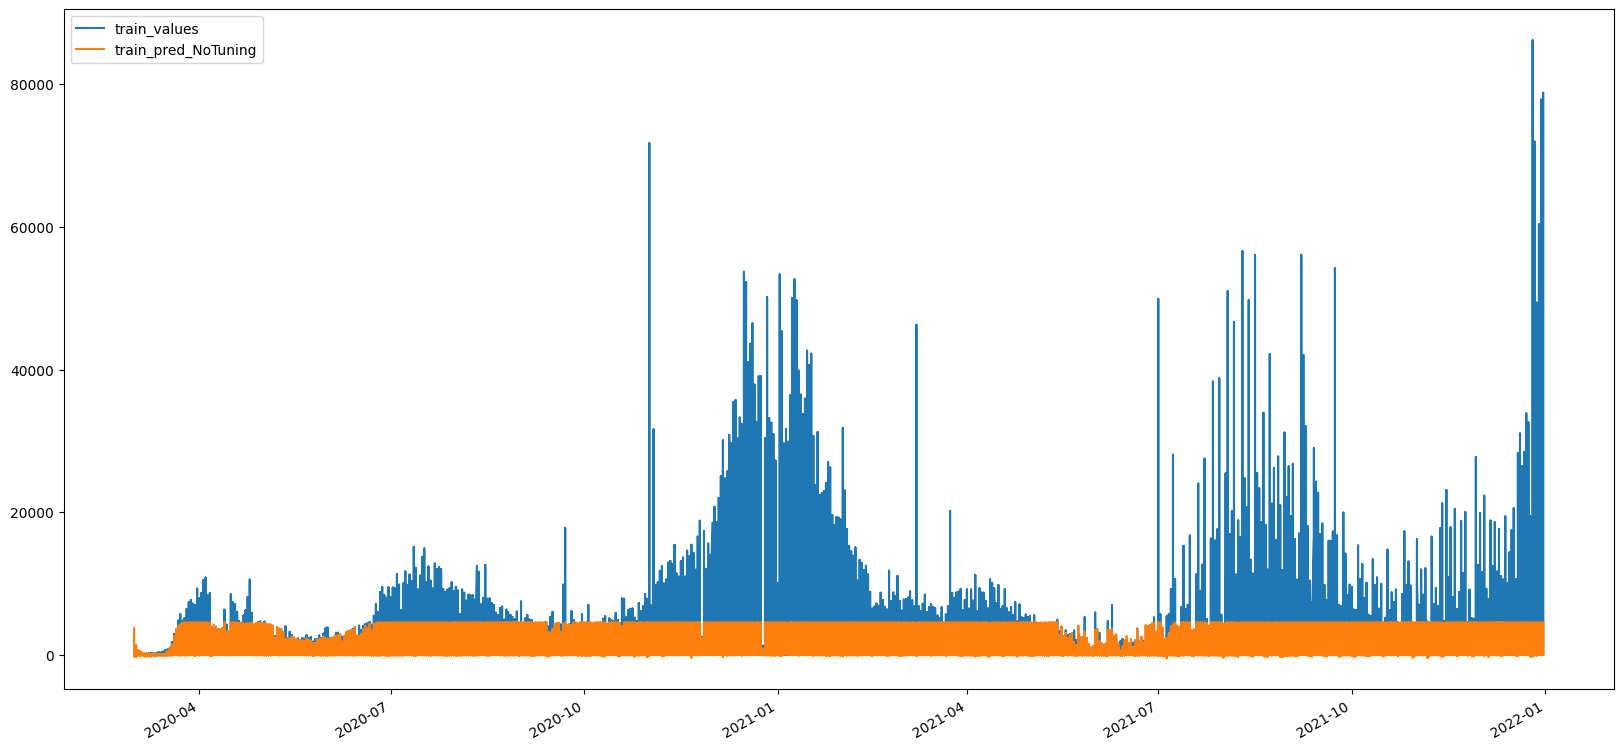

In [25]:
train_pred_NoTuning=pd.DataFrame(final_model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_values= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_values, train_pred_NoTuning], axis=1).plot(figsize=(20,10))
plt.legend(['train_values', 'train_pred_NoTuning'])

In [26]:
# rmse after tuning
np.sqrt(mean_squared_error(train_values, train_pred_NoTuning))

1941.628165537202

In [27]:
final_model = keras.Model(inputs=inputs, outputs=outputs)
final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
final_model.fit(x=x,y=y,epochs=300,batch_size=150,shuffle=True)

Epoch 1/300
448/448 [==============================] - 5s 8ms/step - loss: 3770172.2500
Epoch 2/300
448/448 [==============================] - 3s 7ms/step - loss: 3761998.2500
Epoch 3/300
448/448 [==============================] - 3s 8ms/step - loss: 3756239.0000
Epoch 4/300
448/448 [==============================] - 3s 8ms/step - loss: 3750937.0000
Epoch 5/300
448/448 [==============================] - 3s 8ms/step - loss: 3749898.0000
Epoch 6/300
448/448 [==============================] - 3s 8ms/step - loss: 3741687.2500
Epoch 7/300
448/448 [==============================] - 3s 8ms/step - loss: 3738177.7500
Epoch 8/300
448/448 [==============================] - 3s 8ms/step - loss: 3735104.5000
Epoch 9/300
448/448 [==============================] - 3s 8ms/step - loss: 3728399.0000
Epoch 10/300
448/448 [==============================] - 3s 8ms/step - loss: 3732410.0000
Epoch 11/300
448/448 [==============================] - 3s 7ms/step - loss: 3723714.2500
Epoch 12/300
448/448 [========

In [ ]:
test_pred_NoTuning=final_model.predict(np.array([x[2].reshape(15,21) for x in test]))
test_pred_NoTuning=pd.DataFrame(test_pred_NoTuning, columns=['yhat'], index=[x[0] for x in test ])
test_values=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
plt.plot(test_values)
plt.plot(test_pred_NoTuning)
plt.legend(['test_values', 'test_pred_NoTuning'])

2099/2099 [==============================] - 5s 2ms/step


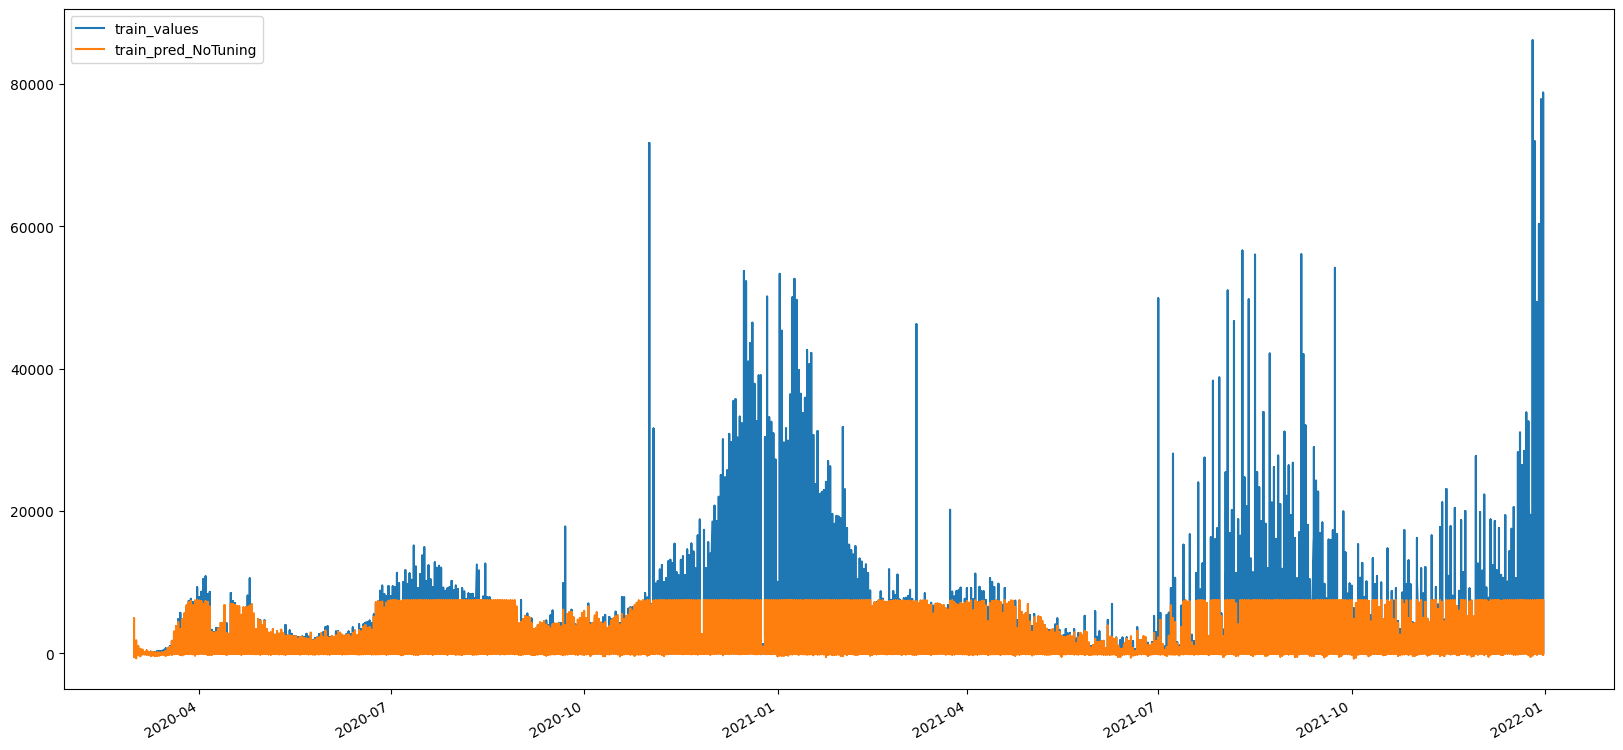

In [28]:
train_pred_NoTuning=pd.DataFrame(final_model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_values= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_values, train_pred_NoTuning], axis=1).plot(figsize=(20,10))
plt.legend(['train_values', 'train_pred_NoTuning'])

In [29]:
# rmse after tuning
np.sqrt(mean_squared_error(train_values, train_pred_NoTuning))

1696.9505364788242